# Automata to forbid/enforce sequence motifs

------------------------------------------------------------

## Online resources and software environment

​

This document is hosted online as [Jupyter notebook](https://www.lix.polytechnique.fr/~will/Software/Infrared/current/Doc/Automata.ipynb) with precomputed results. Download this file to view, edit and run examples in Jupyter.

​

We recommend to install all required software using Mamba (or Conda) and PIP.

```

mamba create -n infrared -c conda-forge infrared jupyter jupytext matplotlib seaborn graphviz

mamba activate infrared

pip install graphviz

mamba deactivate infrared

```

​

Start the Jupyter notebook server after activating the environment

```

mamba activate infrared

jupyter notebook

```

The [original sources](https://gitlab.inria.fr/amibio/Infrared/-/tree/master/Doc/Examples) are part of the Infrared distribution and hosted on Gitlab (in Jupytext light Script format).

​

------------------------------------------------------------

## Enforcing and forbidding sequence motifs by finite deterministic automata

We showcase an Infrared feature network model that forbids (or enforces) the occurrence of any (respectively one) of several given input motifs in randomly generated sequences.
The Infrared model is be based on a finite automaton that we construct from the input motifs/words.

For example, let's generate sequences that avoid the stop codons or any of three restriction sites of EcoRI, BamHI, and HindIII

In [1]:
Sigma="ACGU"

stop_codons = ["UGA", "UAG", "UAA"]

restriction_sites = ["GAAUUC",
                     "GGAUCC",
                     "AAGCUU"
                    ]

words=stop_codons
#words=restriction_sites

In [2]:
import infrared as ir
from collections import defaultdict

A *Deterministic Finite Automaton (DFA)* is a $5$-tuple $(\mathcal{Q},\Sigma,\delta,q_0,\mathcal{Q}_F)$ with

* Finite set of states $\mathcal{Q}$;
* Finite set of symbols $\Sigma$;
* Transition function $\delta:\mathcal{Q}\times\Sigma\to\mathcal{Q}$;
* Initial state $q_0\in\mathcal{Q}$;
* Set of final, accepting states $\mathcal{Q}_F\subset\mathcal{Q}$.


## Construction of an Aho-Corasick automaton

We construct a specific DFA, called *Aho-Corasick automaton*, that accepts strings that contain one of several given words. The general idea of this construction is that the automaton contains one state for every true word prefix; in addition there is a terminal state $. Then, we introduce transitions from states so that the automaton always remembers the longest infix up to current position that can still be extended to an accepted word.

In [3]:
def maxoverlap(s,t):
    for i in reversed(range(min(len(s),(len(t)))+1)):
        if s[-i:] == t[:i]:
            return i
    return 0

def construct_automaton(words, Sigma):
    #
    states = set()
    for w in words:
        for i in range(0,len(w)):
            states.add(w[:i])

    states.add("$")

    # construct transition table as dictionary delta[state][c] = nextstate
    delta = defaultdict(dict)

    for state in states:
        if state=="$":
            for c in Sigma:
                delta[state][c]="$"
            continue
        for c in Sigma:
            s = state+c

            if s in words:
                delta[state][c] = "$"
                continue

            if s in states:
                delta[state][c] = s
                continue

            # find smallest state with largest overlap
            xs = []
            for state2 in states:
                k = maxoverlap(s,state2)
                xs.append((state2,k))
            if len(xs)>0:
                maxk = max(x[1] for x in xs)
                maxstates = [x[0] for x in xs if x[1]==maxk]
                state2=min(maxstates, key=lambda x: len(x))
                delta[state][c]=state2
    return (states,delta)

### Construct for specific instance and visualize

As preparation step, to finally forbid the restriction sites, we are first construting a DFA that recognizes them. 

In [4]:
automaton = construct_automaton(words, Sigma)

snum = len(automaton[0])
print(f'{snum} states')

5 states


In [5]:
import graphviz

def draw_automaton(automaton):
    states,delta = automaton
    
    G=graphviz.Digraph(engine="dot",
    graph_attr=dict(),
    node_attr=dict(fontsize="22pt", fontname="Helvetica",
                   penwidth="3.0", fontcolor="black",
                   shape="rectangle", style="rounded",
                   height="0.4", margin="0.03"),
    edge_attr=dict(color="gray30", penwidth="1.5", arrowsize="0.8"))
    
    for state in states:
        G.node(state)
    for src in delta:
        tgts = defaultdict(list)
        for c in delta[src]:
            tgt = delta[src][c]
            tgts[tgt].append(c)
        for tgt,c in tgts.items():
            G.edge(src,tgt,label=','.join(sorted(c)))
    
    return G

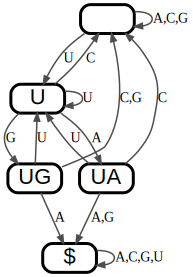

In [6]:
draw_automaton(automaton)

## Automaton feature network

We 'implement' the automaton as Infrared model, by modeling the state at each position by a variable (whose value is the state index) and the transitions by constraints.
For use in our model, we define a constraint to express the transition function $\delta$. To express our model in Infrared, states (and characters) have to be encoded as integers. Thus, before we can express the model, we translate our automaton (including its transition function) to this encoding. 

In [7]:
ir.def_constraint_class('Trans',
    lambda i,delta,var: var([('X',i),('Y',i),('Y',i+1)]),
    lambda xi,yi,yip1,delta: yip1 == delta[yi][xi])

def automaton_to_int_encoding(automaton, Sigma):
    """Convert automaton to an integer encoding
    
    Returns:
        (revintstates, intdelta), where
          * revinstates represents the states as a mapping from state labels to integers
          * intdelta is the delta function on integers for states and characters (w.r.t. Sigma)
          
    """
    states, delta = automaton
    
    
    states=list(states)
    # ensure that the termination state is the last state
    termidx = states.index('$')
    states[termidx],states[-1] = states[-1],states[termidx]
    
    numstates = len(states)
    
    revintstates = {state:x for x,state in enumerate(states)}
        
    intdelta = defaultdict(dict)
    for src in delta:
        for c in delta[src]:
            tgt = delta[src][c]
            intdelta[revintstates[src]][Sigma.index(c)] = revintstates[tgt]
    
    return revintstates, intdelta

    
def automaton_model(n, Sigma, automaton, model=None, negated=False):
    """
    Construct automaton model
    Args:
       Sigma: alphabet
       automaton: actually, only the pair of states and delta of an AC automaton, implicit start at ''
       negated: if False, choose '$' as accepting; if True, every other state
       model: if this is not None, extend the given model by the automaton.
           Given models must define n variables X_i, which encode alphabet characters.
    Returns:
        The constructed model
    """
    
    # sort the alphabet
    Sigma = sorted(Sigma)
    
    # unless a model is already provided, construct it
    # ()
    if model is None:
        model = ir.Model()
        model.add_variables(n, len(Sigma), name='X')
    
    states, delta = automaton_to_int_encoding(automaton, Sigma)
    
    q0 = states['']
    qf = states['$']
    
    numstates = len(states)
    
    model.add_variables(1,   (q0,q0),'Y')
    if not negated:
        model.add_variables(n-1, numstates ,'Y')
        model.add_variables(1,   (qf,qf), 'Y')
    else:
        model.add_variables(n, (0,qf-1) ,'Y')
    
    
    model.add_constraints( Trans(i,delta,model.idx) for i in range(n) )
    
    return model

## Model for our example

Construct the model for our example input words and use it to generate (uniformly drawn) sequences that avoid the input words!

In [8]:
n=100
def a_to_seq(assignment, n, Sigma):
    return "".join([Sigma[i] for i in sample.values()[:n]])

model = automaton_model(n, Sigma, automaton, negated=True)

generate sequences and test whether they contain any input word (if above negated=True, then they must not occur; otherwise one of them must occur)

In [9]:
sampler = ir.Sampler(model)

for _ in range(10):
    sample = sampler.sample()
    seq = a_to_seq(sample,n,Sigma)
    print(seq)
    ## Test whether input words are contained
    for w in words:
        if w in seq: 
            print(f"    {w} occurs")

GAGGUACAAAGUGCUCUACCUCAGUCAUUAUCACGAUCUGGUAUACUACCCACCGAGUGUCAAAUGUUCCUGGACUGGGGGAUCGUUGCGGGCGUAUAUC
CCAAGAAGGACACGAACUCCAGGUUACACAUCAAUUCUGGCUAUCUUCUCAGGCGGCACUGUUUGCCACGAGAUUGUCCUACGAUCGGGAAGACGAGCCC
GGUUCCCGGCAACCCACGGAUCGUUCCACGGGAAGGAAUUUCACGCGGUUACUUGUAUUCAUAUGGCGCACGCCACCUUACGCUUAUUUCUUCGUGCCCA
ACUGCCAGAAAUUGCAGGAGUGGGGCCACCUGCCUCCAAUCGGUGUUCAGUCCACCUUCCGGCACAAGAGUCGACUUACACCUUCUCAAUCGCGUGCGAG
CACGGUUCAGUCGGAACACUGGCUCACACCUUAUGGGAAAGAAACACUUUCGACUUUGCUCCCAUCCCCGGCAAAACGAAUUGGAUCGGUUUGGCCGACC
UGGGCUCUCCCCAUCUGGCCUACAUUCAUCACUGCAAGCUGUGCGAUCAGGCAAUGUCUUAUCCUUUUAUUCCGCGACCAAGACUCGCGUCCAGCCUUUG
CCAAAUUACGUCUUUACCGUGGAACGAAGGAUUUUUACCAAUGGCGAGGUUCUUCGCAAUGCGGGCGGAGGACCCAGGCAGCCGCGCACGCAGCCCGUGG
CAGCACCCAAUAUACUACUUCUACGUCGCAAGAUCACGGAAGAUCAGUCCGUAUGGCAUCUGCAAUUCUAUCCAGAAACGGCGCAAACGUUCCUAUUUCA
GGUCGUGGACAUUCAGUGGUCAGUUCGCCGACCGACUUUGUCCUUUUUGGACACGUACAAAGGACGUAUGUGGUGUACUGCAACACUACAAAAGAAACAC
GGUGCCGCUUCGCAGCCGGGAGCUGGAAGGUGCUGCGGUUACACCAGAAGUAUACCCCUCCACUGUCAAAAAGAUCGUUGUGGCUGGAACC

# APPENDIX

## Combination with multi-target design

In [10]:
from infrared import rna
toy_targets = [
#    012345678901234567890
    "((((...))))(((...)))",
    "((((((.....)))...)))",
    "......(((..)))......",
#    "....((((......)))).."
]


# RNAfold/3str/f3.100.0.inp
benchmark_targets = [
'((((.((....)).)))).((.(((.((((.....(((..((((((.((..(((.(.....).)))..)).)).))))..)))..)))).))).))....',
'..(((((.....(((.(((((((.....))))..))).))).....)))))..((((((((((...))).)....))))))...((((((....))))))',
'......(((((.....(((...(((.((.((.(((....((......))...))).)).)))))..))).............))))).((((...)))).'
]

targets = toy_targets
#targets = benchmark_targets[:2]

In [11]:
def construct_design_model(targets):
    seqlen = len(targets[0])
    ######
    # construct the constraint model
    model = ir.Model()

    # one variable X_i per position i;
    # the value of X_i encodes the nucleotide at position i   
    model.add_variables( seqlen, 4, name='X' )

    for i,target in enumerate(targets):
        bps = rna.parse(target)

        model.add_constraints( rna.BPComp( i, j ) for ( i, j ) in bps )

        model.add_functions( [ rna.BPEnergy( i, j, False ) 
                               for ( i, j ) in bps ], group = f'bpenergy{i}' )

        model.add_feature( f'E{i}', # feature name
                           f'bpenergy{i}', # controlled group(s)
                           #
                           # function to evaluate the feature for a sample;
                           # NOTE how we have to bind i
                           lambda sample, i=i: RNA.energy_of_struct( rna.values_to_seq( sample.values() ),
                                                  targets[i] )
                         )

    model.add_functions( [ rna.GCCont( i = i ) for i in range(seqlen) ], group = 'gc' )


    model.write_graph('dependency_graph.dot', True)
    ir.dotfile_to_pdf('dependency_graph.dot')

    # the model generates automatic features 'bpenergyI', 'gc' from the function groups;
    # as well as total feature combining all function groups;
    # however, we want to diretly control Turner energy (instead of base pair energy).
    # For this purpose, add additional features 'EI'

    return model

In [12]:
model = construct_design_model(targets)

sampler = ir.Sampler(model)
print(f'Treewidth(design): {sampler.treewidth()}')

n= len(targets[0])
print(f'Length: {n}')

model = automaton_model(n, Sigma, automaton, negated=True, model=model)

Treewidth(design): 1
Length: 20


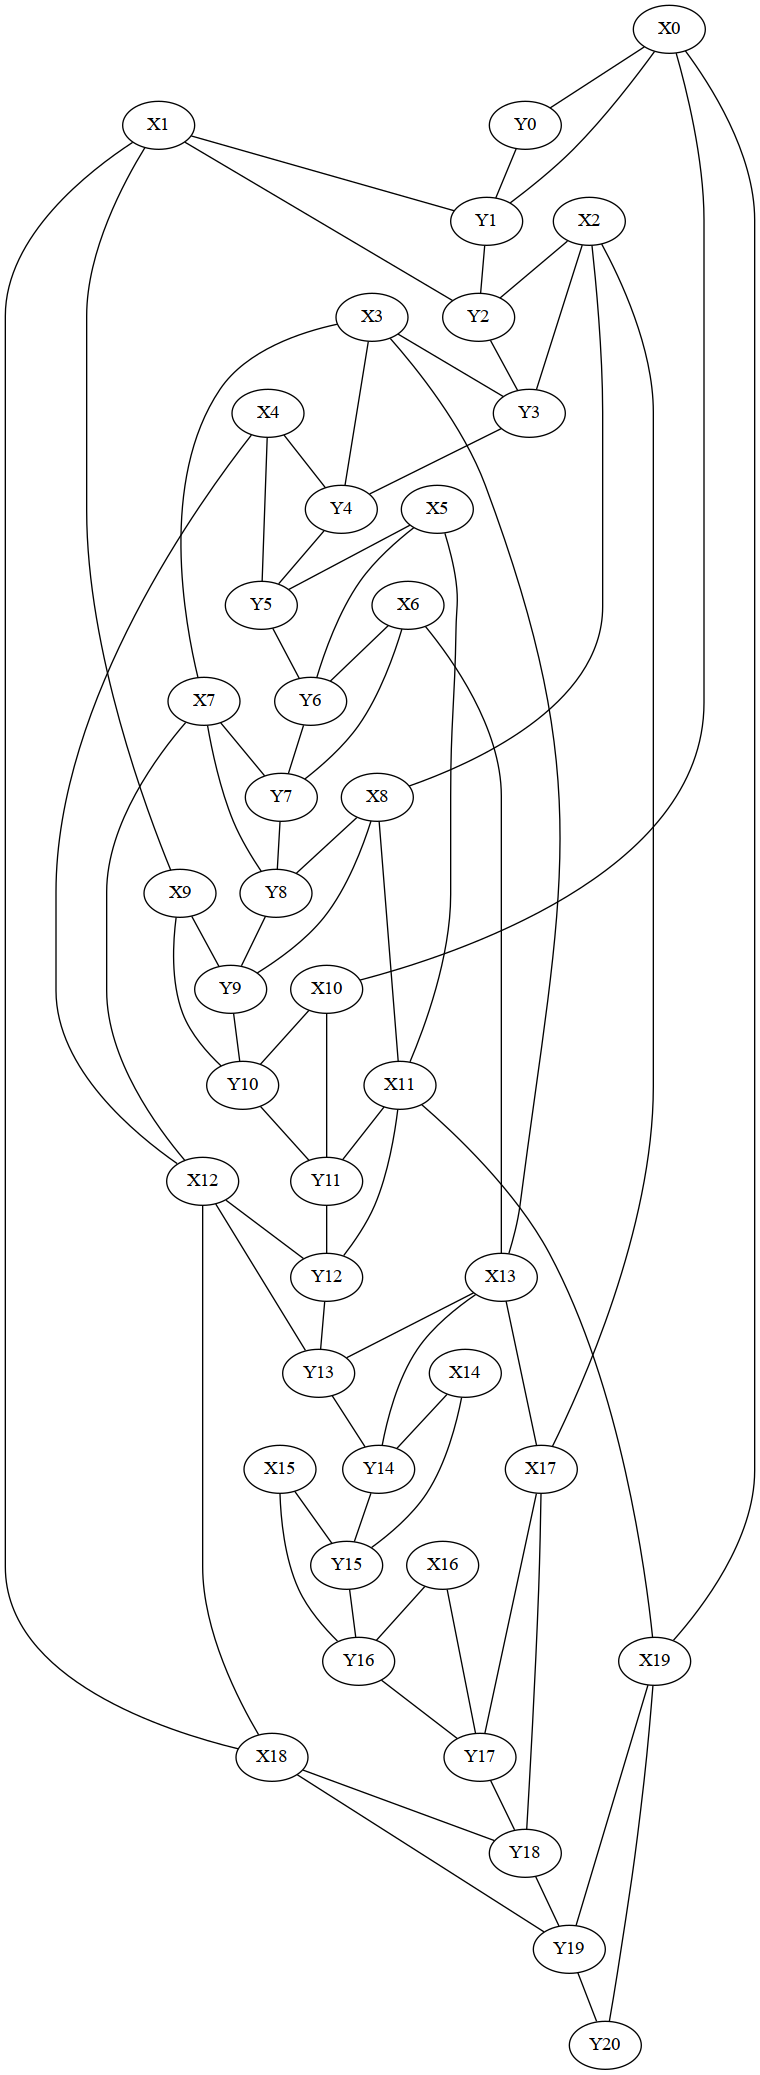

In [13]:
from IPython.display import Image
import re

# Plot dependency graph
filename = 'dependency_graph.dot'
model.write_graph(filename, True)

ir.dotfile_to_png(filename)
filename = re.sub(r"dot$","png",filename)
Image(filename=filename,width=400)

## Compute the tree decomposition - compare different strategies

### Minimize tree width

Here, we additionally set a fixed number of iterations

In [14]:
import treedecomp
from treedecomp import NXTreeDecompositionFactory

weights = [d.size() for d in model.domains]

sampler = ir.Sampler(model,
    td_factory=NXTreeDecompositionFactory(iterations=100,
        adaptive=None,
        #objective="weight", weights=weights
    ))
print(f'Treewidth(design+automaton): {sampler.treewidth()}')

td=sampler.td
print(weights)
bagweights = treedecomp._bagweights(td.bags, weights)
print(bagweights)
print(f"{float(sum(bagweights)):0.2}")

Treewidth(design+automaton): 7
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[65536, 4096, 16384, 16384, 65536, 65536, 16384, 16384, 4096, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 256, 256, 256, 256, 256, 256, 256, 64, 64, 64, 64, 16, 64, 64, 4, 16, 64, 256, 1024, 4096, 16384]
3e+05


### Minimize tree width after 'collapsing' corresponding variables

This is useful to more easily argue worst case bounds in the context of series of corresponding variables with different domain sizes (here, for general FDA, this is the case for X_i and Y_i, which correspond to each other). In practice, this often seems to be significantly worse.

Note that domain sizes happen to be almost uniform for the stop codon automaton.

In [15]:
import treedecomp
from treedecomp import NXTreeDecompositionFactory

n= len(targets[0])

weights = [d.size() for d in model.domains]

sampler = ir.Sampler(model,
    td_factory=NXTreeDecompositionFactory(iterations=100,
        adaptive=None,
        join = lambda i,j: i<n and j==i+n,
        #objective="weight", weights=weights
    ))
print(f'Treewidth(design+automaton): {sampler.treewidth()}')

td=sampler.td
print(weights)
bagweights = treedecomp._bagweights(td.bags, weights)
print(bagweights)
print(f"{float(sum(bagweights)):0.2}")

Treewidth(design+automaton): 11
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[16777216, 1048576, 1048576, 16777216, 1048576, 65536, 65536, 1048576, 1048576, 262144, 16384, 16384, 4096, 4096, 4096, 64, 4, 16, 64, 256, 1024, 4096, 16384, 65536, 262144, 1048576, 4194304, 4194304, 16384, 1024, 1024, 1024, 262144, 262144, 262144, 262144, 4096, 4096, 262144, 16384, 262144]
5.1e+07


### Optimize weight over tree decompositions with low tree width (from min-fill-in)

Experimental feature. Finally, it would be desirable to optimize weight, i.e. the sum over the products of domain sizes per bag, over all possible tree decompositions. This strategy nevertheless typically improves evaluation-time over the non-weighted strategy in the context of non-uniform domain sizes. 

In [16]:
import treedecomp
from treedecomp import NXTreeDecompositionFactory

weights = [d.size() for d in model.domains]
sampler = ir.Sampler(model,
    td_factory=NXTreeDecompositionFactory(iterations=100,
        adaptive=None,
        objective="weight",
        weights=weights))
print(f'Treewidth(design+automaton): {sampler.treewidth()}')

td=sampler.td
print(weights)
bagweights = treedecomp._bagweights(td.bags, weights)
print(bagweights)
print(f"{float(sum(bagweights)):0.2}")

Treewidth(design+automaton): 7
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[65536, 16384, 16384, 65536, 16384, 16384, 16384, 4096, 16384, 4096, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 256, 256, 256, 256, 256, 256, 256, 256, 64, 64, 64, 64, 64, 64, 16, 4, 16, 64, 256, 1024, 4096, 16384]
2.7e+05


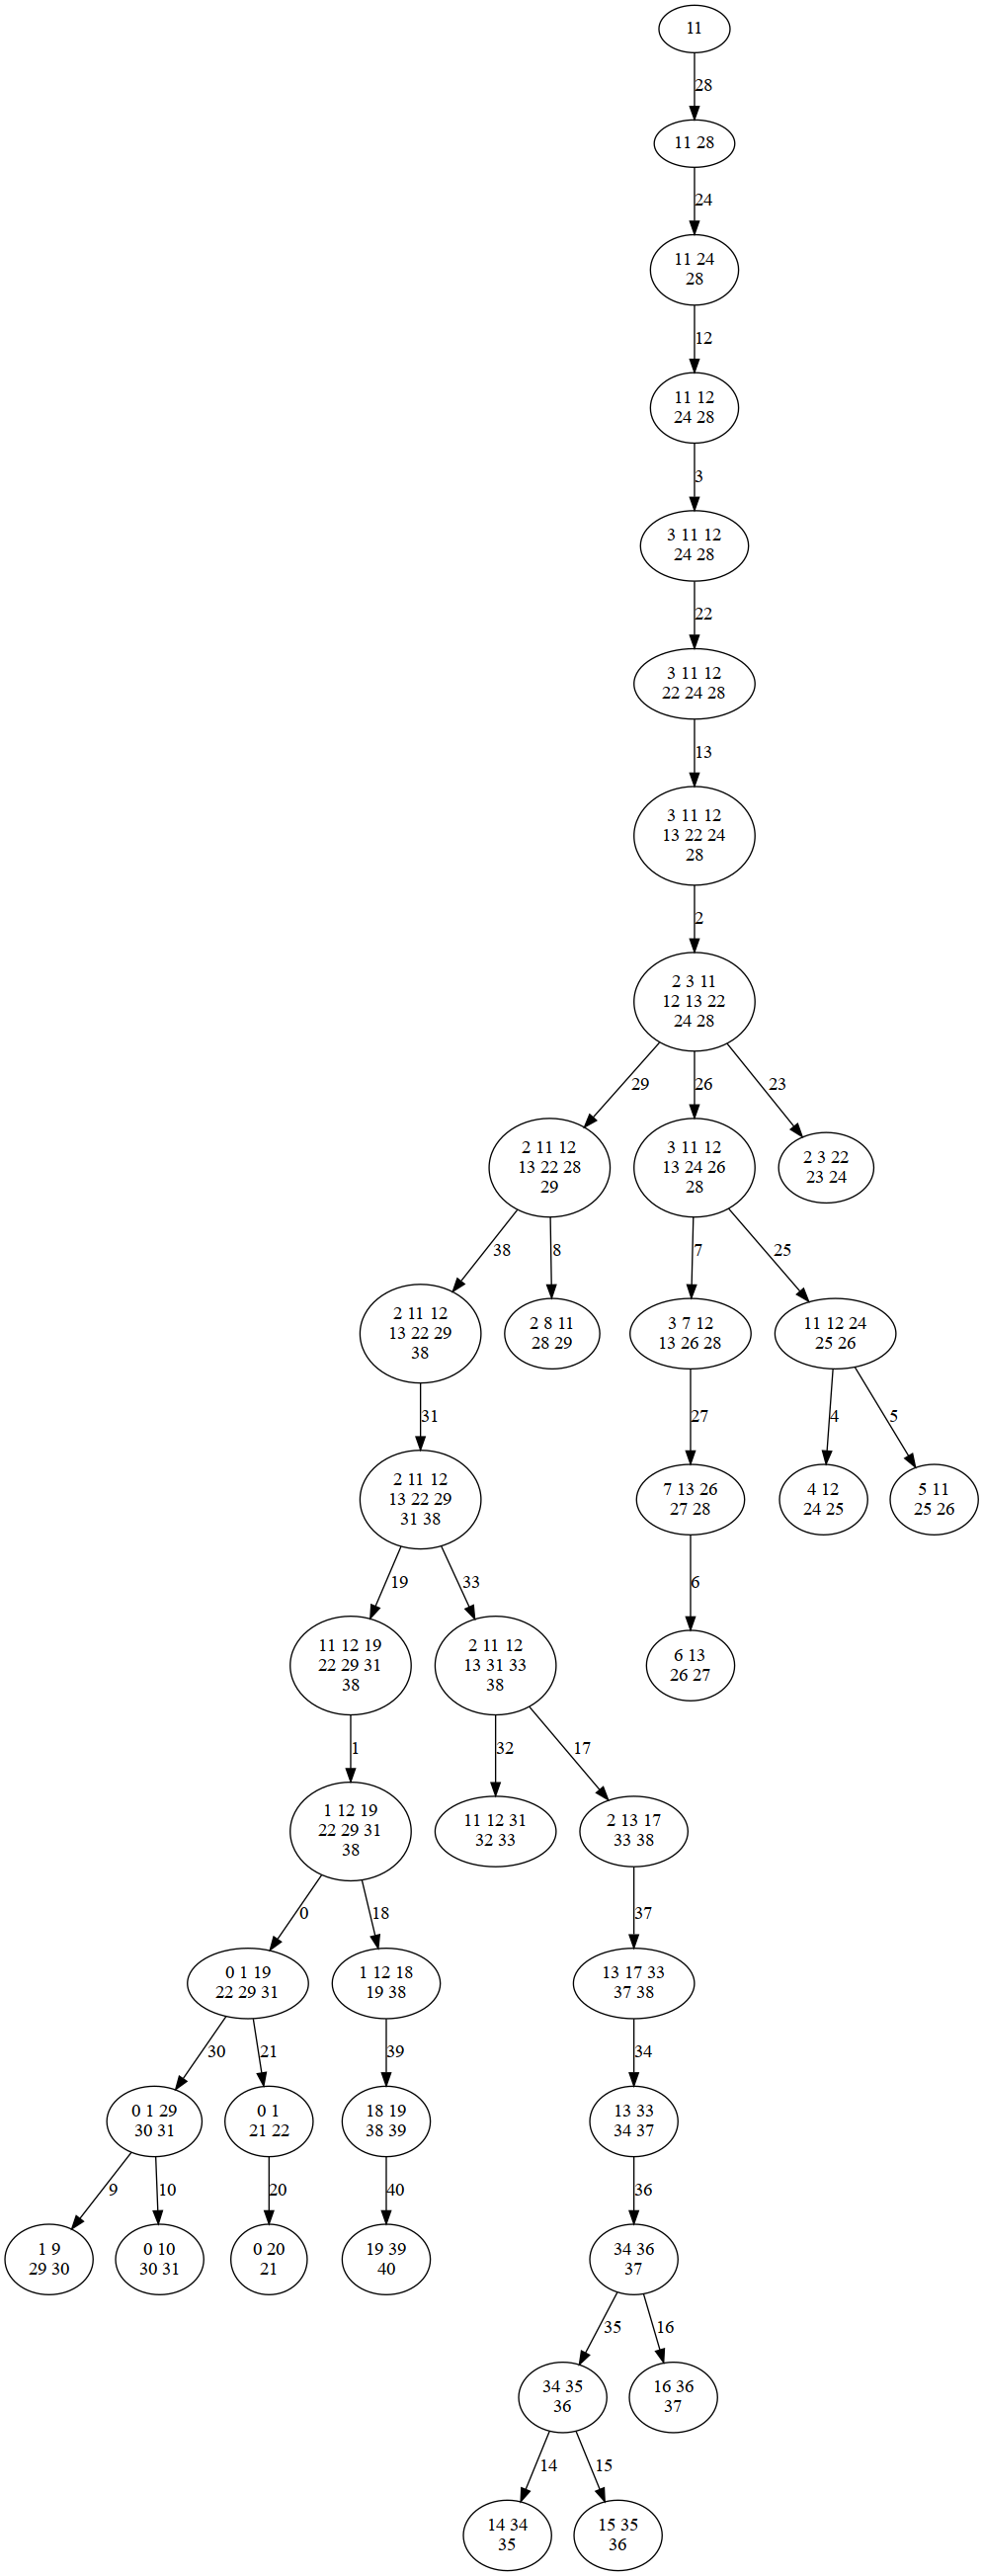

In [17]:
# Plot tree decomposition
filename="treedecomp"
sampler.plot_td(filename,'png')
Image(filename=filename+".png",width=600)

In [18]:
for target in targets:
    print(target)
for sample in (sampler.sample() for _ in range(10)):
    seq = a_to_seq(sample,n,"ACGU")
    print(seq)

((((...))))(((...)))
((((((.....)))...)))
......(((..)))......
GUACGUCGUACGUGCGUUAU
GCGCAUCGCGCGUGGAACGU
GUGUGUCGUACGUGGGUCAU
UGUGCAGCAUGUGCAACGCG
UAUGUGGCGUGCGUGGUAUG
UGUACAGUACGUGUCAGAUG
GUAUACUAUGUGUAUCAUGC
UGUGCAGUGCAUGUACCGUA
GUGUGUUGUGCAUGUGCUAU
GUGUGUUAUGUGUGUAUUAU
